Follow the notebook to get started with the second part of the challenge which is to load the data, encode it to quantum circuit, visualize it and examine scaling for different encodings and image resolutions. 

Load the inference

In [46]:
import sys
sys.path.append('./QCNN_inference_pyc.zip')
from QCNN_inference import qcnn_circuit, load_breastmnist_data

Visualize a sample from the breastMNIST dataset

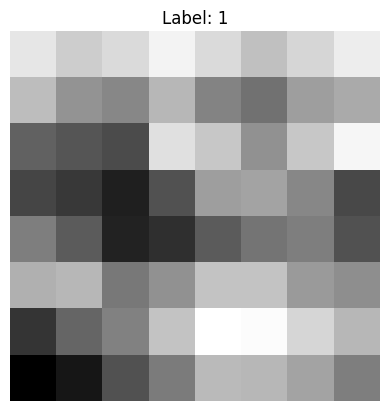

In [47]:
# Load a small sample of BreastMNIST images (resized to 8×8)
# Fetches 10 training and 10 test images
x_train, y_train, x_test, y_test = load_breastmnist_data(num_train=10, num_test=10)

# Select a single example for visualization and encoding
features_sample = x_train[0]
label = y_train[0]

# Show the original image
import matplotlib.pyplot as plt
plt.imshow(features_sample.reshape(8, 8), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


TypeError: Invalid shape (64,) for image data

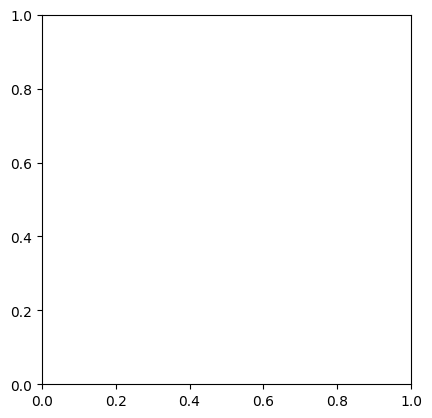

In [48]:
plt.imshow(x_train[0])

In [ ]:
from qiskit import ClassicalRegister
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer
import numpy as np

def visualize_qcnn_with_measurement(weights, last_layer_params, features, num_qubits=6, filename=None):
    """
    Builds the QCNN circuit, adds measurement to final decision qubit, and visualizes it.
    """
    qc, final_qubits = qcnn_circuit(
        weights, last_layer_params, features, num_qubits=num_qubits
    )

    # Add a classical register if none exists
    if not qc.cregs:
        creg = ClassicalRegister(1, name="c")
        qc.add_register(creg)
    else:
        creg = qc.cregs[0]

    # Add a measurement to the decision qubit (q0)
    qc.measure(final_qubits[0], creg[0])

    # Draw and optionally save
    circuit_drawer(qc, output="mpl", fold=-1, style={"fontsize": 12, "subfontsize": 10})
    plt.show()

    if filename:
        qc.draw(output="mpl", fold=-1, style={"fontsize": 12, "subfontsize": 10}).savefig(filename, dpi=300)
        print(f"✅ Circuit saved to {filename}")

    return qc

# Normalize for amplitude embedding
num_qubits = 6
features_padded = np.zeros(2**num_qubits)
features_padded[:64] = features_sample
features_padded /= np.linalg.norm(features_padded)

# Dummy weights (random for visualization)
weights_sample = np.random.rand(2, 18)   # Two layers, 18 parameters
last_layer_params = np.random.rand(15)   # Final SU(4) layer


visualize_qcnn_with_measurement(weights_sample, last_layer_params, features_sample, num_qubits, filename="qcnn_with_measurement.png")

✅ Circuit saved to qcnn_with_measurement.png


#### Having viewed a sample circuit for the fixed 6 qubit QCNN, from here on your task is to visualize a few samples of the encoded images (before and after encoding), vary the encoding methodologies and examine the circuit scaling.

Example of amplitude encoding

In [ ]:
#amplitude encoding
def amplitude_embedding_block(features: np.ndarray, num_qubits: int, pad_with=0.5, label="AmpEmbed"):
    """
    Create a subcircuit that prepares a state with amplitudes equal to the normalized feature vector.
    This mimics PennyLane's AmplitudeEmbedding.
    """

    # ✅ Ensure features is a NumPy array
    feat = np.asarray(features, dtype=np.float64)

    # ✅ Check if `feat` is still a scalar
    if feat.ndim == 0:
        raise ValueError(f"`features` should be an array, but got a scalar: {features}")


    # Ensure the feature vector has the correct length
    dim = 2 ** num_qubits
    
    if len(feat) < dim:
        feat = np.concatenate([feat, np.full(dim - len(feat), pad_with)])
    elif len(feat) > dim:
        raise ValueError(f"Feature length {len(feat)} exceeds 2^{num_qubits} = {dim}.")
    
    # Normalize
    norm = np.linalg.norm(feat) + 1e-10
    feat = feat / norm
    
    # Create a circuit and use the initialize method to prepare the state exactly
    encoding_circuit = QuantumCircuit(num_qubits, name=label)
    encoding_circuit.initialize(feat, list(range(num_qubits)))
    
    encoding_circuit.barrier()
    return encoding_circuit.to_instruction()

## QCNN Circuit Assembly

The `qcnn_circuit(...)` function below builds the full quantum circuit using:

1. A **data encoding block** (currently: Amplitude Embedding),
2. A stack of **convolution + pooling layers**,
3. A final **dense SU(4) layer**,
4. **No measurement** — this is added separately when needed.


### Your Task:

Replace the **amplitude embedding** block with a different encoding method of your choice:
-  **Angle Encoding:** apply `Ry(x[i])` or `Rz(x[i])` to each qubit,
-  **FRQI:** encode pixel intensity as rotation phase,
-  **QPIE:** map data using both position and intensity,
-  **Custom:** get creative, but make sure the feature vector matches the number of qubits!

You’ll do this by modifying the **encoding block** inside the function.


### Encoding Block to Replace

Inside the code below, you’ll see:
```python
# 2) Amplitude embedding
embed_gate = amplitude_embedding_block(features, num_qubits, pad_with=0.5, label="AmpEmbed")
qc.append(embed_gate, qargs=all_qubits)


Sample code for qcnn_circuit

In [ ]:
#qcnn_circuit

#Parametrizable circuit embedding


Amplitude_embedding=True
Angle_embedding_ry=False
Angle_embedding_rz=False
FQRI=False
QPIE=False
Custom = False

# Ensure exactly one embedding method is selected


def qcnn_circuit(
    weights,              # shape: (layers, total_params_per_layer)
    last_layer_unitary,   # 15 params for your final 2-qubit gate or a 4x4 matrix
    features,             # input features (for amplitude encoding)
    num_qubits_amp=6,Amplitude_embedding=True,
Angle_embedding_ry=False,
Angle_embedding_rz=False,
FQRI=False,
QPIE=False,
Custom = False
):
    if int(Amplitude_embedding) + int(Angle_embedding_ry) + int(FQRI) + int(QPIE) + int(Custom) + int(Angle_embedding_rz)  != 1:
        raise ValueError("🚨 ERROR: Exactly one embedding method must be selected.")

    """
    Build a Qiskit circuit that:
      1. Amplitude-embeds 'features' into 'num_qubits' qubits
      2. Applies convolution + pooling layers
      3. Applies a final dense 2-qubit SU(4) gate from PennyLane
      4. ❌ Does NOT include a measurement — handled separately

    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        qubits_in_use (list): The final subset of qubits after pooling.
    """

    features = np.asarray(features, dtype=np.float64)

    if features.ndim == 0:
        raise ValueError(f"🚨 ERROR: `features` should be a 1D or 2D array, but got scalar {features}")

    # 1) Main circuit without classical register
    qc = None # To make qc global
    

    # 2a) Amplitude embedding
    if Amplitude_embedding:
        qc = QuantumCircuit(num_qubits_amp)
        all_qubits = list(range(num_qubits_amp))
        embed_gate = amplitude_embedding_block(features, num_qubits_amp, pad_with=0.5, label="AmpEmbed")
        qc.append(embed_gate, qargs=all_qubits)
    # 2b) Angle embedding Ry
    if Angle_embedding_ry:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
           
            qc.ry(features[i], i)
    # 2c) Angle embedding Rz
    if Angle_embedding_rz:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
            qc.rz(features[i], i)
    # 2d) FQRI embedding
    if FQRI:
       if FQRI:
        len_data = len(features)
        num_pos = int(np.ceil(np.log2(len_data)))
        # One qubit to store the color 
        num_qubits = num_pos + 1
        qc = QuantumCircuit(num_qubits)
        
        all_qubits = list(range(num_qubits))
        position_qubits = list(range(num_pos))
        color_qubit_index = num_pos 

        
        angles = features * (np.pi / 2)/255 # The feature are grayscale from 0 to 255
        for p in position_qubits:
            qc.h(p) # maximally entangled state i.e sum |i>
 
        for i, angle in enumerate(angles):
            
            control_state = format(i, f'0{num_pos}b') # find the binary string for the position pixel
            
            for j, bit in enumerate(control_state):
                if bit == '0': #make sure to flip the control qubit if the bit is 0
                    qc.x(j)
            
            multi_controll= RYGate(2*angle).control(len(position_qubits),label=None) #building of the multi controlled RY gate cf https://quantumcomputing.stackexchange.com/questions/27077/qiskit-custom-multi-controlled-gate
            qc.append(multi_controll, position_qubits + [color_qubit_index])

            for j, bit in enumerate(control_state):
                if bit == '0':
                    qc.x(j) # reset the control qubit
    
    if QPIE:
        l_2_norm= np.linalg.norm(features)
        normalized_features= features/l_2_norm
        len_data = len(normalized_features)
        qc = QuantumCircuit(len_data)
        qc.initialize(normalized_features, list(len_data))

    # 3) Convolution + Pooling
    layers = layers = len(weights)
    qubits_in_use = all_qubits.copy()

    for layer_idx in range(layers):
        if len(qubits_in_use) <= 2:
            break

        kernel_weights = weights[layer_idx]
        skip = layer_idx != 0
        qubits_in_use = conv_and_pooling(qc, kernel_weights, qubits_in_use, skip_first_layer=skip)

    # 4) Final Dense Layer
    if len(qubits_in_use) != 2:
        raise ValueError(f"After pooling, expected exactly 2 qubits, got {len(qubits_in_use)}.")

    if 0 not in qubits_in_use:
        raise ValueError(f"Final qubits do not include q0: {qubits_in_use}")

    # Ensure q0 is first
    if qubits_in_use[1] == 0:
        qubits_in_use = [qubits_in_use[1], qubits_in_use[0]]

    # ✅ Use PennyLane's ArbitraryUnitary → Qiskit's UnitaryGate wrapper
    dense_gate(qc, last_layer_unitary, qubits_in_use[0], qubits_in_use[1])

    return qc, qubits_in_use

In [ ]:
def encoder(
    weights,              # shape: (layers, total_params_per_layer)
    last_layer_unitary,   # 15 params for your final 2-qubit gate or a 4x4 matrix
    features,             # input features (for amplitude encoding)
    num_qubits_amp=6,Amplitude_embedding=True,
Angle_embedding_ry=False,
Angle_embedding_rz=False,
FQRI=False,
QPIE=False,
Custom = False
):
    if int(Amplitude_embedding) + int(Angle_embedding_ry) + int(FQRI) + int(QPIE) + int(Custom) + int(Angle_embedding_rz)  != 1:
        raise ValueError("🚨 ERROR: Exactly one embedding method must be selected.")

    """
    Build a Qiskit circuit that:
      1. Amplitude-embeds 'features' into 'num_qubits' qubits
      2. Applies convolution + pooling layers
      3. Applies a final dense 2-qubit SU(4) gate from PennyLane
      4. ❌ Does NOT include a measurement — handled separately

    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        qubits_in_use (list): The final subset of qubits after pooling.
    """

    features = np.asarray(features, dtype=np.float64)

    if features.ndim == 0:
        raise ValueError(f"🚨 ERROR: `features` should be a 1D or 2D array, but got scalar {features}")

    # 1) Main circuit without classical register
    qc = None # To make qc global
    

    # 2a) Amplitude embedding
    if Amplitude_embedding:
        qc = QuantumCircuit(num_qubits_amp)
        all_qubits = list(range(num_qubits_amp))
        embed_gate = amplitude_embedding_block(features, num_qubits_amp, pad_with=0.5, label="AmpEmbed")
        qc.append(embed_gate, qargs=all_qubits)
    # 2b) Angle embedding Ry
    if Angle_embedding_ry:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
           
            qc.ry(features[i], i)
    # 2c) Angle embedding Rz
    if Angle_embedding_rz:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
            qc.rz(features[i], i)
    # 2d) FQRI embedding
    
    if FQRI:
        len_data = len(features)
        num_pos = int(np.ceil(np.log2(len_data)))
        # One qubit to store the color 
        num_qubits = num_pos + 1
        qc = QuantumCircuit(num_qubits)
        
        all_qubits = list(range(num_qubits))
        position_qubits = list(range(num_pos))
        color_qubit_index = num_pos 

        
        angles = features * (np.pi / 2)/255 # The feature are grayscale from 0 to 255
        for p in position_qubits:
            qc.h(p) # maximally entangled state i.e sum |i>
 
        for i, angle in enumerate(angles):
            
            control_state = format(i, f'0{num_pos}b') # find the binary string for the position pixel
            
            for j, bit in enumerate(control_state):
                if bit == '0': #make sure to flip the control qubit if the bit is 0
                    qc.x(j)
            
            multi_controll= qc.RYGate(2*angle).control(len(position_qubits),label=None) #building of the multi controlled RY gate cf https://quantumcomputing.stackexchange.com/questions/27077/qiskit-custom-multi-controlled-gate
            qc.append(multi_controll, position_qubits + [color_qubit_index])

            for j, bit in enumerate(control_state):
                if bit == '0':
                    qc.x(j) # reset the control qubit
    
    if QPIE:
        l_2_norm= np.linalg.norm(features)
        normalized_features= features/l_2_norm
        len_data = len(normalized_features)
        qc = QuantumCircuit(len_data)
        qc.initialize(normalized_features, list(len_data))
    return qc


In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli

def decode_ry_encoding(ry_circuit, simulation_method='statevector', shots=8192):
    
    num_qubits = ry_circuit.num_qubits
    reconstructed_angles = []

    for i in range(num_qubits):
        # To find the angle on qubit 'i', we must measure its <X> expectation value.
        
        # --- 1. PERFECT DECODING (STATEVECTOR) ---
        if simulation_method == 'statevector':
            state = Statevector(ry_circuit)
            # Create an operator that is Identity on all qubits except for X on qubit i
            op = Pauli('I' * (num_qubits - 1 - i) + 'X' + 'I' * i) #the expectation value of X is sin(theta)
            
            # For a state from RY(theta), <X> = sin(theta)
            expectation_value = state.expectation_value(op).real
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)

        # --- 2. REALISTIC DECODING (SHOTS) ---
        elif simulation_method == 'shots':
            # To measure in the X-basis, apply an H gate before measuring
            qc = ry_circuit.copy()
            cr = ClassicalRegister(1, name="c")
            qc.add_register(cr)
            qc.h(i)
            qc.measure(i, cr)
            
            backend = AerSimulator()
            job = backend.run(qc, shots=shots)
            counts = job.result().get_counts()
            
            # The expectation value <X> is P(0) - P(1)
            p0 = counts.get('0', 0) / shots
            p1 = counts.get('1', 0) / shots
            expectation_value = p0 - p1
            
            # Solve for theta: arcsin(<X>) = theta
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)
            
        else:
            raise ValueError("simulation_method must be 'statevector' or 'shots'")
    
    return np.array(reconstructed_angles)

In [ ]:
def encoder_ry(features):
    """A simple encoder for RY angle encoding."""
    qc = QuantumCircuit(len(features))
    for i, feature in enumerate(features):
        print(i)
        qc.ry(feature, i)
    return qc

# 1. Define original features (angles)
original_features = np.array([0.5, 1.2, np.pi/2, -0.3])

# 2. Encode the features using RY gates
ry_circuit = encoder_ry(original_features)
print("test")
ry_circuit.draw()

print("--- 🔬 Decoding Angle (RY) Encoding ---")

# 3. Decode using the perfect statevector method
rec_ry_sv = decode_ry_encoding(ry_circuit, 'statevector')

# 4. Decode using the realistic shots-based method
rec_ry_shots = decode_ry_encoding(ry_circuit, 'shots')

print("Original Angles:      ", np.round(original_features, 4))
print("Reconstructed (SV):   ", np.round(rec_ry_sv, 4))
print("Reconstructed (Shots):", np.round(rec_ry_shots, 4))

0
1
2
3
test
--- 🔬 Decoding Angle (RY) Encoding ---
Original Angles:       [ 0.5     1.2     1.5708 -0.3   ]
Reconstructed (SV):    [ 0.5     1.2     1.5708 -0.3   ]
Reconstructed (Shots): [ 0.5096  1.2161  1.5708 -0.3022]


In [ ]:
import numpy as np
import math
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile

def encoder_frqi(features):
    """Creates a corrected FRQI circuit using the |position> ⊗ |color> convention."""
    num_pixels = len(features)
    num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
    num_qubits = num_pos_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    # --- CONVENTION FIX ---
    # Qubit 0 is the color qubit (LSB)
    color_qubit_index = 0
    # Qubits 1, 2, ... are the position qubits
    position_qubits = list(range(1, num_qubits))
    # -----------------------

    angles = (features / 255.0) * (np.pi / 2)
    
    qc.h(position_qubits)
    
    for i, angle in enumerate(angles):
        if np.isclose(angle, 0): continue
        
        # The control state string for the position qubits
        control_state = format(i, f'0{num_pos_qubits}b')
        
        # Reverse the string to match Qiskit's LSB-first qubit indexing for position
        for j, bit in enumerate(reversed(control_state)):
            # j=0 corresponds to the LSB of position, which is qubit 1
            # j=1 corresponds to the next bit, which is qubit 2, etc.
            if bit == '0': qc.x(position_qubits[j])
        
        mcr_gate = RYGate(2 * angle).control(num_pos_qubits)
        # The controls are the position qubits, the target is the color qubit
        qc.append(mcr_gate, position_qubits + [color_qubit_index])

        # Un-compute the X-gates
        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
            
    return qc

In [ ]:
def decode_frqi(frqi_circuit, simulation_method='statevector', shots=8192):
    """Decodes an FRQI state using the |position> ⊗ |color> convention."""
    num_qubits = frqi_circuit.num_qubits
    num_pos_qubits = num_qubits - 1
    num_pixels = 2**num_pos_qubits
    
    if simulation_method == 'statevector':
        state = Statevector(frqi_circuit)
        data = state.data
        reconstructed_pixels = []
        for i in range(num_pixels):
            # --- CONVENTION FIX ---
            # Index for |pos, color=0> is the integer for the state where the color bit (q0) is 0.
            # This is simply the position value 'i' shifted left by 1 bit.
            idx0 = i << 1 
            # Index for |pos, color=1> is the same, but with the color bit (q0) as 1.
            idx1 = (i << 1) + 1
            # -----------------------

            amp0 = data[idx0]
            amp1 = data[idx1]
            
            angle = np.arctan2(np.real(amp1), np.real(amp0))
            pixel_value = (angle / (np.pi / 2)) * 255
            reconstructed_pixels.append(pixel_value)
        return np.array(reconstructed_pixels)

    elif simulation_method == 'shots':
        # This part of the code from the previous fix was already assuming the
        # correct little-endian format from Qiskit's counts, so it requires minimal changes.
        # The counts key 'p...c' corresponds to |...position...color>.
        qc = frqi_circuit.copy()
        cr = ClassicalRegister(num_qubits)
        qc.add_register(cr)
        qc.measure(range(num_qubits), range(num_qubits))
        
        backend = AerSimulator()
        transpiled_qc = transpile(qc, backend)
        job = backend.run(transpiled_qc, shots=shots)
        counts = job.result().get_counts()

        reconstructed_pixels = []
        for i in range(num_pixels):
            # Qiskit's count key is MSB...LSB, so '...pos...color'
            pos_state = format(i, f'0{num_pos_qubits}b')
            
            count0 = counts.get(pos_state + '0', 0)
            count1 = counts.get(pos_state + '1', 0)
            total_pos_counts = count0 + count1
            
            if total_pos_counts == 0:
                angle = 0
            else:
                prob_color_1 = count1 / total_pos_counts
                angle = np.arcsin(np.sqrt(prob_color_1))
            
            pixel_value = (angle / (np.pi / 2)) * 255
            reconstructed_pixels.append(pixel_value)
        return np.array(reconstructed_pixels)

In [ ]:
# 1. Define original 2x2 image (4 pixels)
image_shape = (4 ,4)
original_features = np.array([0, 85, 170, 255,192,12,2,3,4,5,6,7,8,14,15,16])

# 2. Encode the features using the CORRECTED FRQI method
frqi_circuit = encoder_frqi(original_features)

print("--- 🖼️ Decoding FRQI (Final Correction) ---")

# 3. Decode using the perfect statevector method
rec_frqi_sv = decode_frqi(frqi_circuit, 'shots')

print("Original Image:\n", original_features.reshape(image_shape))
print("\nReconstructed (Statevector):\n", np.round(rec_frqi_sv).reshape(image_shape))

--- 🖼️ Decoding FRQI (Final Correction) ---
Original Image:
 [[  0  85 170 255]
 [192  12   2   3]
 [  4   5   6   7]
 [  8  14  15  16]]

Reconstructed (Statevector):
 [[  0.  89. 166. 255.]
 [189.  10.   0.   0.]
 [  0.   0.  10.   7.]
 [  0.  14.  16.  16.]]


In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RYGate
ccry = RYGate(np.pi/8).control(2,label=None)
circ = QuantumCircuit(4)
circ.append(ccry,[0,1,3])
circ.draw()

q_0: ──────────────■─────────────────■──
                   │                 │  
q_1: ──────────────■─────────────────■──
     ┌──────────┐┌─┴─┐┌───────────┐┌─┴─┐
q_2: ┤ Ry(π/16) ├┤ X ├┤ Ry(-π/16) ├┤ X ├
     └──────────┘└───┘└───────────┘└───┘
q_3: ───────────────────────────────────

Loading BreastMNIST dataset...
Encoding the 32x32 image...
FRQI circuit created with 11 qubits.

Decoding with statevector simulator (perfect reconstruction)...
Decoding with shots simulator (realistic reconstruction)...


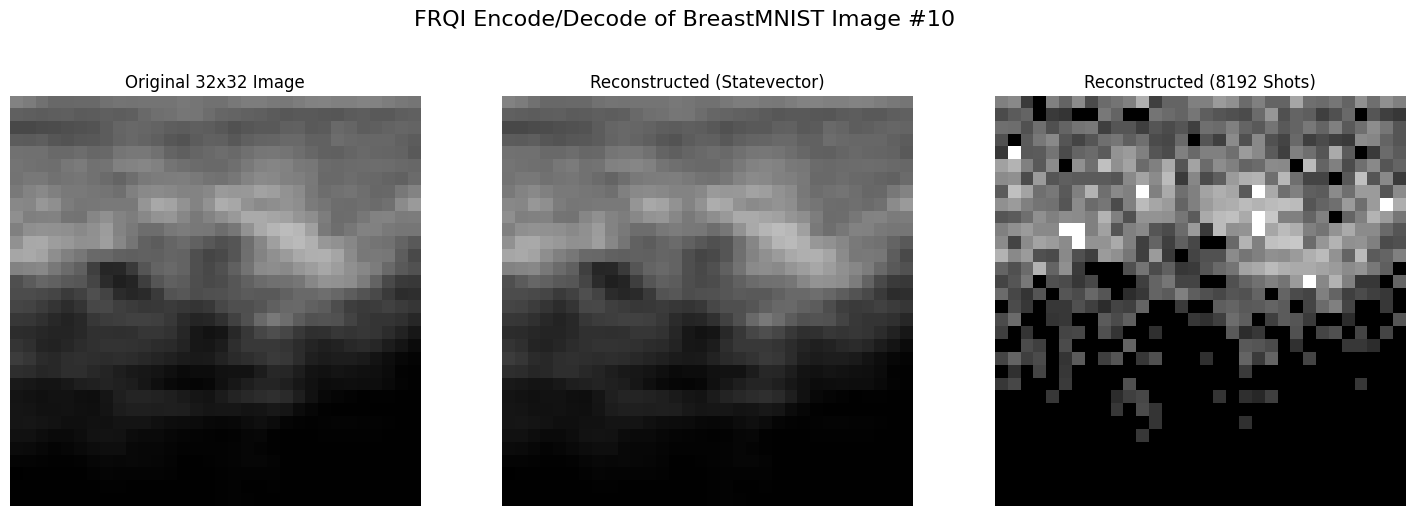

In [51]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image

from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile

# MedMNIST for the dataset
import medmnist
from medmnist import BreastMNIST

# --- Step 1: Paste the corrected Encoder and Decoder functions ---

def encoder_frqi(features):
    """Creates a corrected FRQI circuit using the |position> ⊗ |color> convention."""
    num_pixels = len(features)
    num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
    num_qubits = num_pos_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    color_qubit_index = 0
    position_qubits = list(range(1, num_qubits))

    angles = (features / 255.0) * (np.pi / 2)
    qc.h(position_qubits)
    
    for i, angle in enumerate(angles):
        if np.isclose(angle, 0): continue
        control_state = format(i, f'0{num_pos_qubits}b')
        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
        
        mcr_gate = RYGate(2 * angle).control(num_pos_qubits)
        qc.append(mcr_gate, position_qubits + [color_qubit_index])

        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
            
    return qc

def decode_frqi(frqi_circuit, simulation_method='statevector', shots=1024):
    """Decodes an FRQI state, with transpilation for shots-based simulation."""
    num_qubits = frqi_circuit.num_qubits
    num_pos_qubits = num_qubits - 1
    num_pixels = 2**num_pos_qubits
    
    if simulation_method == 'statevector':
        state = Statevector(frqi_circuit)
        data = state.data
        reconstructed_pixels = []
        for i in range(num_pixels):
            idx0 = i << 1 
            idx1 = (i << 1) + 1
            amp0, amp1 = data[idx0], data[idx1]
            angle = np.arctan2(np.real(amp1), np.real(amp0))
            pixel_value = (angle / (np.pi / 2)) * 255
            reconstructed_pixels.append(pixel_value)
        return np.array(reconstructed_pixels)

    elif simulation_method == 'shots':
        backend = AerSimulator()
        qc = frqi_circuit.copy()
        
        cr = ClassicalRegister(num_qubits)
        qc.add_register(cr)
        qc.measure(range(num_qubits), range(num_qubits))
        
        transpiled_qc = transpile(qc, backend)
        job = backend.run(transpiled_qc, shots=shots)
        counts = job.result().get_counts()

        reconstructed_pixels = []
        for i in range(num_pixels):
            pos_state = format(i, f'0{num_pos_qubits}b')
            count0 = counts.get(pos_state + '0', 0)
            count1 = counts.get(pos_state + '1', 0)
            total_pos_counts = count0 + count1
            
            if total_pos_counts == 0:
                angle = 0
            else:
                prob_color_1 = count1 / total_pos_counts
                angle = np.arcsin(np.sqrt(prob_color_1))
            
            pixel_value = (angle / (np.pi / 2)) * 255
            reconstructed_pixels.append(pixel_value)
        return np.array(reconstructed_pixels)

# --- Step 2: Load and Pre-process a BreastMNIST image ---

print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)

# Select an image (e.g., the 10th image in the dataset)
IMAGE_INDEX = 10
pil_image, label = train_dataset[IMAGE_INDEX]

# Pre-process the image for FRQI
TARGET_SIZE = (32, 32) # 8x8 = 64 pixels = 2^6 pixels
image_resized = pil_image.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
image_np = np.array(image_resized)
features = image_np.flatten() # Flatten the 2D image to a 1D vector

# --- Step 3: Encode and Decode the Image ---

print(f"Encoding the {TARGET_SIZE[0]}x{TARGET_SIZE[1]} image...")
frqi_circuit = encoder_frqi(features)
# For an 8x8=64 pixel image, we need log2(64)=6 position qubits + 1 color qubit
print(f"FRQI circuit created with {frqi_circuit.num_qubits} qubits.")

print("\nDecoding with statevector simulator (perfect reconstruction)...")
reconstructed_sv = decode_frqi(frqi_circuit, 'statevector')
image_sv = reconstructed_sv.reshape(TARGET_SIZE)

print("Decoding with shots simulator (realistic reconstruction)...")
reconstructed_shots = decode_frqi(frqi_circuit, 'shots', shots=8192)
image_shots = reconstructed_shots.reshape(TARGET_SIZE)

# --- Step 4: Visualize the Results ---

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'FRQI Encode/Decode of BreastMNIST Image #{IMAGE_INDEX}', fontsize=16)

axes[0].imshow(image_np, cmap='gray', vmin=0, vmax=255)
axes[0].set_title(f"Original {TARGET_SIZE[0]}x{TARGET_SIZE[1]} Image")
axes[0].axis('off')

axes[1].imshow(image_sv, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Reconstructed (Statevector)")
axes[1].axis('off')

axes[2].imshow(image_shots, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Reconstructed (8192 Shots)")
axes[2].axis('off')

plt.show()

### Encode, Decode & Evaluate Your Image

Once you've selected and implemented your image encoding scheme (Amplitude, QPIE, Angle, etc.), it's time to test how well it preserves the information in the image.

#### Example Output


Here’s a visualization of a 64×64 BreastMNIST sample before and after reconstruction using QPIE:

![Sample breastMNIST decoded](breastMNIST_encode_decode.png)

Left: Original image (Benign case)

Right: Reconstructed image after encoding + decoding with QPIE

You should generate similar visuals for each encoding method you experiment with.

#### What You Need to Do

Choose a BreastMNIST sample and resize it to 8×8, 16×16, 32×32, and 64×64 resolutions.

Implement an encoding + decoding pipeline:

Encode image → quantum state

Measure or decode → reconstructed image

Compare original vs reconstructed visually and quantitatively.

#### Metrics to Report

For each encoding method and image resolution:

Compute MSE (Mean Squared Error)

Compute SSIM (Structural Similarity Index)

Vary the number of shots (e.g. 1024, 4096, … up to 1M) to simulate measurement noise

Then, plot something like this: ![Encoding Fidelity](encoding.png)

This shows how reconstruction fidelity changes with number of shots.

Loading BreastMNIST dataset...

--- Processing Resolution: 8x8 ---
Encoding 8x8 image on 7 qubits...
Encoding took 0.07 seconds.
Decoding with statevector...
Decoding with 1024 shots...
  -> MSE: 644.30, SSIM: 0.8721 (took 0.60s)
Decoding with 4096 shots...
  -> MSE: 119.71, SSIM: 0.9755 (took 0.62s)
Decoding with 8192 shots...
  -> MSE: 54.30, SSIM: 0.9891 (took 0.58s)
Decoding with 16384 shots...
  -> MSE: 24.85, SSIM: 0.9954 (took 0.57s)
Decoding with 32768 shots...
  -> MSE: 13.09, SSIM: 0.9972 (took 0.62s)
Decoding with 65536 shots...
  -> MSE: 7.42, SSIM: 0.9987 (took 0.59s)

--- Processing Resolution: 16x16 ---
Encoding 16x16 image on 9 qubits...
Encoding took 0.24 seconds.
Decoding with statevector...
Decoding with 1024 shots...
  -> MSE: 4175.29, SSIM: 0.4153 (took 6.05s)
Decoding with 4096 shots...
  -> MSE: 561.14, SSIM: 0.7645 (took 6.10s)
Decoding with 8192 shots...
  -> MSE: 245.45, SSIM: 0.8929 (took 5.99s)
Decoding with 16384 shots...
  -> MSE: 126.18, SSIM: 0.9387 (too

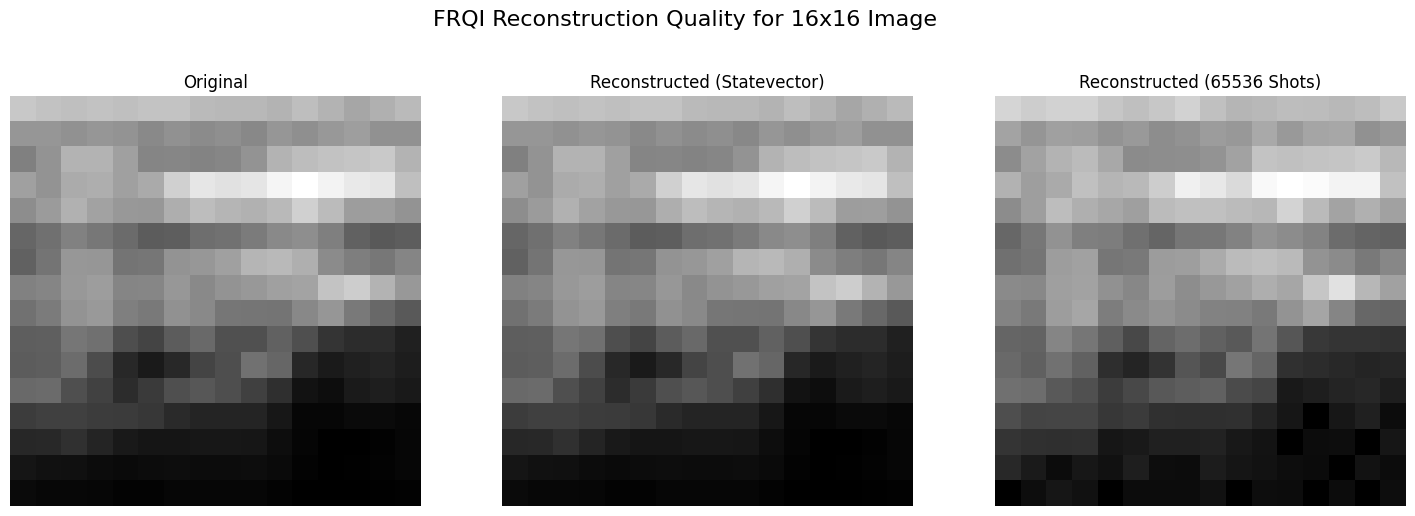

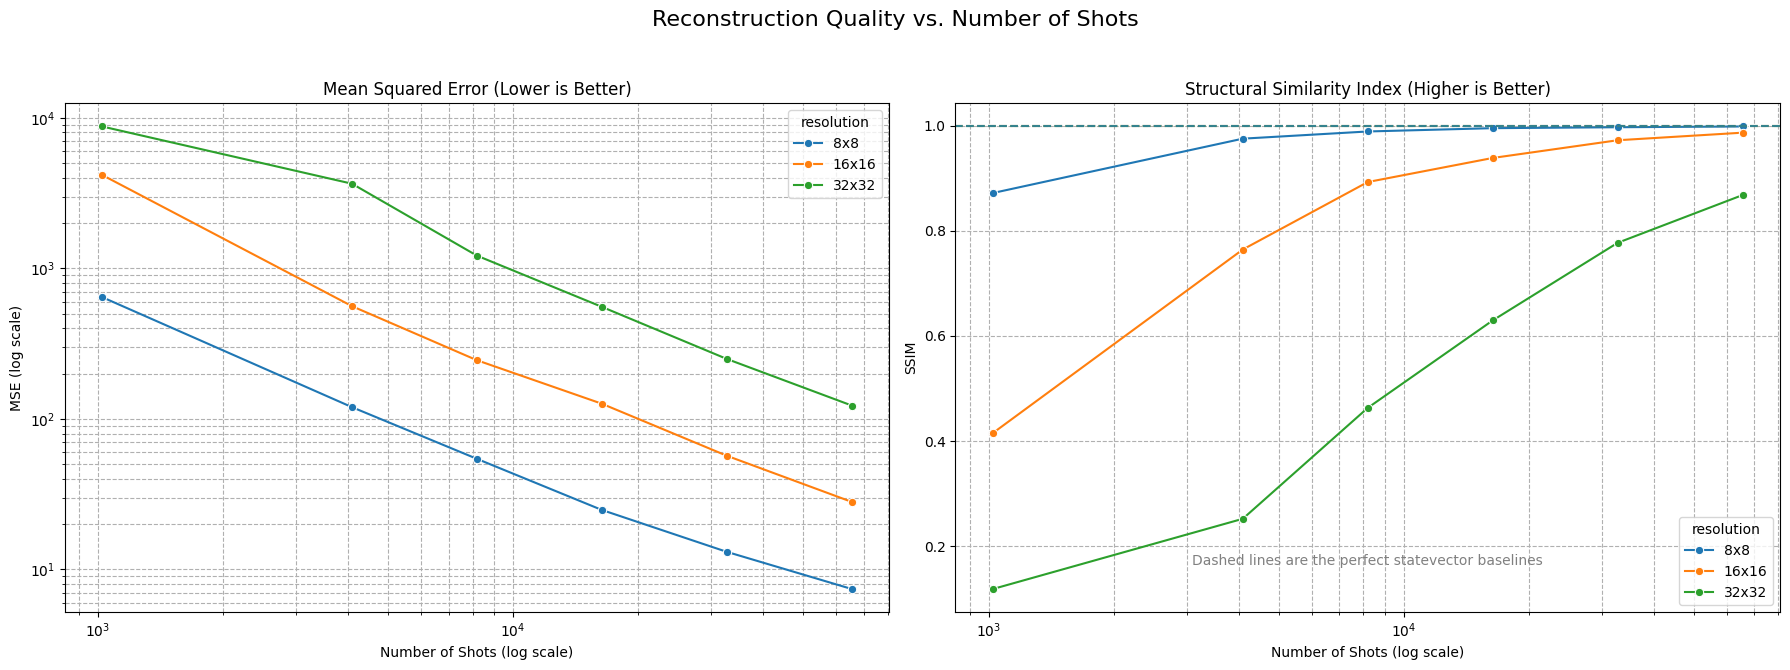

In [52]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import time

# Qiskit Imports
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile

# MedMNIST for the dataset
import medmnist
from medmnist import BreastMNIST

# Scikit-image for metrics
from skimage.metrics import mean_squared_error, structural_similarity

# ===================================================================
# Part 1: Helper Functions (Encoder, Decoder, Metrics)
# ===================================================================

def encoder_frqi(features):
    """Encodes a 1D array of pixel values into an FRQI quantum state."""
    num_pixels = len(features)
    num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
    num_qubits = num_pos_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    color_qubit_index = 0
    position_qubits = list(range(1, num_qubits))

    angles = (features / 255.0) * (np.pi / 2)
    qc.h(position_qubits)
    
    for i, angle in enumerate(angles):
        if np.isclose(angle, 0): continue
        control_state = format(i, f'0{num_pos_qubits}b')
        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
        
        mcr_gate = RYGate(2 * angle).control(num_pos_qubits)
        qc.append(mcr_gate, position_qubits + [color_qubit_index])

        for j, bit in enumerate(reversed(control_state)):
            if bit == '0': qc.x(position_qubits[j])
            
    return qc

def decode_frqi(frqi_circuit, simulation_method='statevector', shots=8192):
    """Decodes an FRQI quantum state back to a classical image array."""
    num_qubits = frqi_circuit.num_qubits
    num_pos_qubits = num_qubits - 1
    num_pixels = 2**num_pos_qubits
    
    if simulation_method == 'statevector':
        state = Statevector(frqi_circuit)
        data = state.data
        reconstructed_pixels = np.zeros(num_pixels)
        for i in range(num_pixels):
            idx0, idx1 = (i << 1), (i << 1) + 1
            amp0, amp1 = data[idx0], data[idx1]
            angle = np.arctan2(np.real(amp1), np.real(amp0))
            reconstructed_pixels[i] = (angle / (np.pi / 2)) * 255
        return reconstructed_pixels

    elif simulation_method == 'shots':
        backend = AerSimulator()
        qc = frqi_circuit.copy()
        
        cr = ClassicalRegister(num_qubits)
        qc.add_register(cr)
        qc.measure(range(num_qubits), range(num_qubits))
        
        transpiled_qc = transpile(qc, backend)
        job = backend.run(transpiled_qc, shots=shots)
        counts = job.result().get_counts()

        reconstructed_pixels = np.zeros(num_pixels)
        for i in range(num_pixels):
            pos_state = format(i, f'0{num_pos_qubits}b')
            count0 = counts.get(pos_state + '0', 0)
            count1 = counts.get(pos_state + '1', 0)
            total = count0 + count1
            angle = 0 if total == 0 else np.arcsin(np.sqrt(count1 / total))
            reconstructed_pixels[i] = (angle / (np.pi / 2)) * 255
        return reconstructed_pixels

def calculate_metrics(original_img, reconstructed_img):
    """Calculates MSE and SSIM between two images."""
    mse = mean_squared_error(original_img, reconstructed_img)
    # data_range is crucial for SSIM
    ssim = structural_similarity(original_img, reconstructed_img, data_range=255)
    return mse, ssim

# ===================================================================
# Part 2: The Main Experiment
# ===================================================================

# --- Configuration ---
RESOLUTIONS = [8, 16, 32] # 64x64 is very slow, starting with 8, 16, 32
SHOT_COUNTS = [1024, 4096, 8192, 16384, 32768, 65536]
IMAGE_INDEX = 42 # Choose a sample image from the dataset

# --- Load Data ---
print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)
pil_image, label = train_dataset[IMAGE_INDEX]

# --- Run Experiment Loop ---
results = []
reconstructed_images = {} # To store some images for visual comparison

for res in RESOLUTIONS:
    print(f"\n--- Processing Resolution: {res}x{res} ---")
    target_size = (res, res)
    
    # 1. Pre-process Image
    image_resized = pil_image.resize(target_size, Image.Resampling.LANCZOS)
    original_np = np.array(image_resized)
    features = original_np.flatten()
    reconstructed_images[res] = {'original': original_np}
    
    # 2. Encode Image (once per resolution)
    start_time = time.time()
    print(f"Encoding {res}x{res} image on {int(np.log2(res**2))+1} qubits...")
    frqi_circuit = encoder_frqi(features)
    print(f"Encoding took {time.time() - start_time:.2f} seconds.")
    
    # 3. Decode with Statevector (perfect baseline)
    print("Decoding with statevector...")
    rec_sv = decode_frqi(frqi_circuit, 'statevector')
    reconstructed_images[res]['statevector'] = rec_sv.reshape(target_size)
    baseline_mse, baseline_ssim = calculate_metrics(original_np, rec_sv.reshape(target_size))
    
    # 4. Decode with varying shots
    for shots in SHOT_COUNTS:
        start_time = time.time()
        print(f"Decoding with {shots} shots...")
        rec_shots = decode_frqi(frqi_circuit, 'shots', shots=shots)
        
        mse, ssim = calculate_metrics(original_np, rec_shots.reshape(target_size))
        
        results.append({
            'resolution': f"{res}x{res}",
            'shots': shots,
            'mse': mse,
            'ssim': ssim,
            'baseline_ssim': baseline_ssim # Store baseline for plotting
        })
        print(f"  -> MSE: {mse:.2f}, SSIM: {ssim:.4f} (took {time.time() - start_time:.2f}s)")

        if shots == SHOT_COUNTS[-1]: # Save the highest shot count image
            reconstructed_images[res]['shots'] = rec_shots.reshape(target_size)

# Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results)

# ===================================================================
# Part 3: Visualization
# ===================================================================

# --- 1. Visual Comparison of Reconstructed Images ---
res_to_show = 16 # Choose a resolution to display
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'FRQI Reconstruction Quality for {res_to_show}x{res_to_show} Image', fontsize=16)
axes[0].imshow(reconstructed_images[res_to_show]['original'], cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(reconstructed_images[res_to_show]['statevector'], cmap='gray')
axes[1].set_title('Reconstructed (Statevector)')
axes[1].axis('off')
axes[2].imshow(reconstructed_images[res_to_show]['shots'], cmap='gray')
axes[2].set_title(f'Reconstructed ({SHOT_COUNTS[-1]} Shots)')
axes[2].axis('off')
plt.show()


# --- 2. Quantitative Metric Plots ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Reconstruction Quality vs. Number of Shots', fontsize=16)

# MSE Plot
sns.lineplot(data=results_df, x='shots', y='mse', hue='resolution', marker='o', ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Mean Squared Error (Lower is Better)')
axes[0].set_xlabel('Number of Shots (log scale)')
axes[0].set_ylabel('MSE (log scale)')
axes[0].grid(True, which="both", ls="--")

# SSIM Plot
sns.lineplot(data=results_df, x='shots', y='ssim', hue='resolution', marker='o', ax=axes[1])
# Add horizontal lines for the perfect statevector baseline SSIM
for res_str, group in results_df.groupby('resolution'):
    axes[1].axhline(y=group['baseline_ssim'].iloc[0], color=sns.color_palette()[list(results_df.resolution.unique()).index(res_str)], linestyle='--', alpha=0.7)
axes[1].set_xscale('log')
axes[1].set_title('Structural Similarity Index (Higher is Better)')
axes[1].set_xlabel('Number of Shots (log scale)')
axes[1].set_ylabel('SSIM')
axes[1].grid(True, which="both", ls="--")
axes[1].text(0.5, 0.1, 'Dashed lines are the perfect statevector baselines', 
             ha='center', va='center', transform=axes[1].transAxes, 
             fontsize=10, color='gray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [55]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli

def decode_ry_encoding(ry_circuit, 
                       simulation_method='statevector', 
                       shots=8192, 
                       backend_method='statevector'):
    """
    Decodes an RY-encoded circuit, with an option for tensor network simulation.
    """
    num_qubits = ry_circuit.num_qubits
    reconstructed_angles = []

    # For large qubit counts, statevector simulation is not possible.
    if num_qubits > 20 and simulation_method == 'statevector':
        raise ValueError(f"Statevector simulation for {num_qubits} qubits is not feasible.")

    for i in range(num_qubits):
        # Statevector method remains the same, as it doesn't use the Aer backend directly
        if simulation_method == 'statevector':
            state = Statevector(ry_circuit)
            op = Pauli('I' * (num_qubits - 1 - i) + 'X' + 'I' * i)
            expectation_value = state.expectation_value(op).real
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)

        elif simulation_method == 'shots':
            qc = ry_circuit.copy()
            cr = ClassicalRegister(1, name="c")
            qc.add_register(cr)
            qc.h(i)
            qc.measure(i, cr)
            
            # --- THE CHANGE IS HERE ---
            # Select the simulation method for the backend
            backend = AerSimulator(method=backend_method)
            # -----------------------
            
            job = backend.run(qc, shots=shots)
            counts = job.result().get_counts()
            
            p0 = counts.get('0', 0) / shots
            p1 = counts.get('1', 0) / shots
            expectation_value = p0 - p1
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)
    
    return np.array(reconstructed_angles)

def encoder_ry(features):
    """Encodes a 1D array of pixel values using RY angle encoding."""
    angles = (features / 255.0) * np.pi
    qc = QuantumCircuit(len(features))
    for i, angle in enumerate(angles):
        qc.ry(angle, i)
    return qc

Loading BreastMNIST dataset...
Encoding 16x16 image on 256 qubits...
Encoding complete.

Decoding with Tensor Network Simulator (this may take a few minutes)...
Decoding complete.


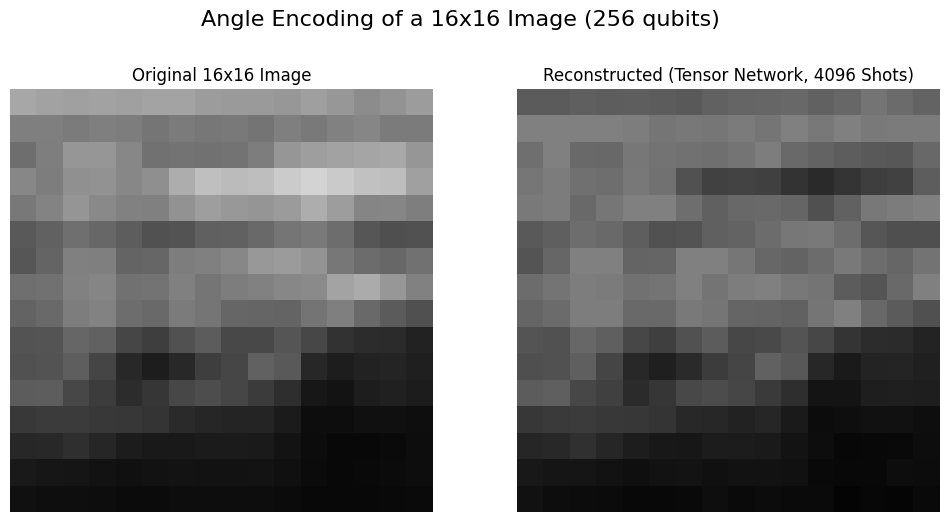

In [57]:
from PIL import Image
import medmnist
from medmnist import BreastMNIST
import matplotlib.pyplot as plt

# --- 1. Load and Pre-process a 16x16 Image ---
print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)
pil_image, label = train_dataset[42]

TARGET_SIZE = (16, 16)
image_resized = pil_image.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
original_np = np.array(image_resized)
features = original_np.flatten() # 256 features

# --- 2. Encode the 256-pixel image ---
print(f"Encoding {TARGET_SIZE[0]}x{TARGET_SIZE[1]} image on {len(features)} qubits...")
ry_circuit = encoder_ry(features)
print("Encoding complete.")

# --- 3. Decode using Tensor Network Simulator ---
# Note: We can only use the 'shots' method. 'statevector' would require too much memory.
print("\nDecoding with Tensor Network Simulator (this may take a few minutes)...")
rec_angles_tn = decode_ry_encoding(ry_circuit, 
                                   simulation_method='shots', 
                                   shots=4096, 
                                   backend_method='matrix_product_state')

# Convert angles back to pixel values
rec_pixels_tn = (rec_angles_tn / np.pi) * 255.0
image_tn = rec_pixels_tn.reshape(TARGET_SIZE)
print("Decoding complete.")

# --- 4. Visualize the Results ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f'Angle Encoding of a 16x16 Image ({len(features)} qubits)', fontsize=16)

axes[0].imshow(original_np, cmap='gray', vmin=0, vmax=255)
axes[0].set_title(f"Original {TARGET_SIZE[0]}x{TARGET_SIZE[1]} Image")
axes[0].axis('off')

axes[1].imshow(image_tn, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Reconstructed (Tensor Network, 4096 Shots)")
axes[1].axis('off')

plt.show()

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import time

# Qiskit Imports
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli

# MedMNIST for the dataset
import medmnist
from medmnist import BreastMNIST

# Scikit-image for metrics
from skimage.metrics import mean_squared_error, structural_similarity

# ===================================================================
# Part 1: Helper Functions
# ===================================================================

def encoder_ry(features):
    """Encodes a 1D array of pixel values using RY angle encoding."""
    angles = (features / 255.0) * np.pi
    qc = QuantumCircuit(len(features))
    for i, angle in enumerate(angles):
        qc.ry(angle, i)
    return qc

def decode_ry_encoding(ry_circuit, 
                       simulation_method='statevector', 
                       shots=8192, 
                       backend_method='statevector'):
    """Decodes an RY-encoded circuit, with an option for tensor network simulation."""
    num_qubits = ry_circuit.num_qubits
    reconstructed_angles = []

    if num_qubits > 20 and simulation_method == 'statevector':
        raise ValueError(f"Statevector simulation for {num_qubits} qubits is not feasible.")

    for i in range(num_qubits):
        # Statevector method is fast and can be done once
        if simulation_method == 'statevector':
            if i == 0: # Only calculate the full statevector once
                state = Statevector(ry_circuit)
            op = Pauli('I' * (num_qubits - 1 - i) + 'X' + 'I' * i)
            expectation_value = state.expectation_value(op).real
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)

        elif simulation_method == 'shots':
            qc = ry_circuit.copy()
            cr = ClassicalRegister(1, name="c")
            qc.add_register(cr)
            qc.h(i)
            qc.measure(i, cr)
            
            backend = AerSimulator(method=backend_method)
            job = backend.run(qc, shots=shots, fusion_enable=False) # Fusion can be slow for many qubits
            counts = job.result().get_counts()
            
            p0 = counts.get('0', 0) / shots
            p1 = counts.get('1', 0) / shots
            expectation_value = p0 - p1
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)
    
    return np.array(reconstructed_angles)

def calculate_metrics(original_img, reconstructed_img):
    """Calculates MSE and SSIM between two images."""
    mse = mean_squared_error(original_img, reconstructed_img)
    ssim = structural_similarity(original_img, reconstructed_img, data_range=255)
    return mse, ssim

# ===================================================================
# Part 2: The Main Experiment
# ===================================================================

# --- Configuration ---
RESOLUTIONS = [8] # Only 8x8 is feasible due to the N-qubit requirement
SHOT_COUNTS = [1024, 4096, 8192, 16384]
IMAGE_INDEX = 42

# --- Load Data ---
print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)
pil_image, label = train_dataset[IMAGE_INDEX]

# --- Run Experiment Loop ---
results = []

for res in RESOLUTIONS:
    num_qubits = res * res
    print(f"\n--- Processing Resolution: {res}x{res} ({num_qubits} qubits) ---")
    target_size = (res, res)
    
    # 1. Pre-process Image
    image_resized = pil_image.resize(target_size, Image.Resampling.LANCZOS)
    original_np = np.array(image_resized)
    features = original_np.flatten()
    
    # 2. Encode Image
    print(f"Encoding {res}x{res} image...")
    ry_circuit = encoder_ry(features)
    
    
    # 4. Decode with varying shots
    for shots in SHOT_COUNTS:
        start_time = time.time()
        print(f"Decoding with {shots} shots (this will be slow)...")
        rec_angles_shots = decode_ry_encoding(ry_circuit, 'shots', shots=shots, backend_method='matrix_product_state')
        rec_pixels_shots = (rec_angles_shots / np.pi) * 255.0
        
        mse, ssim = calculate_metrics(original_np, rec_pixels_shots.reshape(target_size))
        
        results.append({
            'resolution': f"{res}x{res}",
            'shots': shots,
            'mse': mse,
            'ssim': ssim,
            'baseline_ssim': baseline_ssim
        })
        print(f"  -> MSE: {mse:.2f}, SSIM: {ssim:.4f} (took {time.time() - start_time:.2f}s)")

results_df = pd.DataFrame(results)

# ===================================================================
# Part 3: Visualization
# ===================================================================

print("\nGenerating plots...")

# --- Quantitative Metric Plots ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Reconstruction Quality vs. Number of Shots (Angle Encoding, 8x8 Image)', fontsize=16)

# MSE Plot
sns.lineplot(data=results_df, x='shots', y='mse', hue='resolution', marker='o', ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_title('Mean Squared Error (Lower is Better)')
axes[0].set_xlabel('Number of Shots (log scale)')
axes[0].set_ylabel('MSE')
axes[0].grid(True, which="both", ls="--")

# SSIM Plot
sns.lineplot(data=results_df, x='shots', y='ssim', hue='resolution', marker='o', ax=axes[1])
axes[1].axhline(y=results_df['baseline_ssim'].iloc[0], color='r', linestyle='--', label='Statevector Baseline')
axes[1].set_xscale('log')
axes[1].set_title('Structural Similarity Index (Higher is Better)')
axes[1].set_xlabel('Number of Shots (log scale)')
axes[1].set_ylabel('SSIM')
axes[1].grid(True, which="both", ls="--")
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Loading BreastMNIST dataset...

--- Processing Resolution: 8x8 (64 qubits) ---
Encoding 8x8 image...
Decoding with statevector...


ValueError: Statevector simulation for 64 qubits is not feasible.

## QCNN Scaling Plot: What You’ll Need to Replicate

Next step is to compare **different data encoding strategies** (Amplitude, Angle, QPIE, etc.) and analyze how they affect the **scaling behavior** of a Quantum Convolutional Neural Network (QCNN) circuit.

#### This includes plotting how metrics like:
- **Total Gate Count**
- **CX (CNOT) Gate Count**
- **Circuit Depth**

change as you increase:
1. The **picture resolution** (e.g. 8x8 → 16x16)
2. The **encoding method** (Amplitude vs Angle vs QPIE, etc.)

#### What to Plot & Report

Use your imagination and scientific judgment to create informative visualizations. Your plots should:

Show how the circuit scales with input size and encoding method

Highlight any bottlenecks in circuit depth or entanglement gates

Compare different encodings side by side where possible

Justify your findings using relevant literature

### We are happy to help!